In [173]:
#Imports

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import classification_report
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# jesse. jesse we have to train. 

In [174]:
full_drugs = pd.read_csv(r'full_drug_dataset.csv')

In [175]:
# massages the dataset, so the features section is only personality traits, and the labels section is binarized + 
# only the chosen drug 
cols = []
featured = full_drugs.iloc[:, full_drugs.columns != 'Amphet']
for column in featured:
    cols.append(column)
label = 'Amphet'
full_drugs['Amphet'] = full_drugs['Amphet'].map({'CL0': 0, 
                                            'CL1': 0, 
                                            'CL2': 1, 
                                            'CL3': 1, 
                                            'CL4': 1, 
                                            'CL5': 1,
                                            'CL6': 1})
X = full_drugs[cols]
y = full_drugs[label]



In [176]:

logit_model=sm.Logit(y, X)               # runs a logit model— we're looking for the features with a p < 0.05
result=logit_model.fit()
results_summary = result.summary2()

print(results_summary)

Optimization terminated successfully.
         Current function value: 0.534957
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.181     
Dependent Variable: Amphet           AIC:              2038.7890 
Date:               2022-12-16 17:28 BIC:              2099.7475 
No. Observations:   1885             Log-Likelihood:   -1008.4   
Df Model:           10               LL-Null:          -1231.9   
Df Residuals:       1874             LLR p-value:      8.8638e-90
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Age           -0.4509    0.0692  -6.5150  0.0000  -0.5865  -0.3152
Gender        -0.6554    0.1214  -5.3994  0.0000  -0.8933  -0.

In [177]:
p_values_tables = results_summary.tables[1]['P>|z|'].tolist()

p_values = {}                   # dictionary of the p_values
for i in range(0, len(p_values_tables)):
    p_values[results_summary.tables[1]['P>|z|'].index[i]] = p_values_tables[i]
    #p_values[i]# p_values_tables[i]

p_values_tailored = {}          # dictionary of all p_values under 0.05, ie the ones that are statistically significant
for i in range(0, len(p_values_tables)):
    if(list(p_values.values())[i] < 0.05):
        p_values_tailored[results_summary.tables[1]['P>|z|'].index[i]] = list(p_values.values())[i]    # if p < 0.05, add to statistically significant table
print(p_values_tailored)

{'Age': 7.266884157937942e-11, 'Gender': 6.687757332475731e-08, 'Education': 0.04432779272147315, 'Country': 1.2928650250907491e-14, 'Ethnicity': 4.1609051405561557e-13, 'Oscore': 0.006157688036376886, 'Cscore': 0.014459789549504942, 'Impulsive': 1.2177204749194008e-05}


In [178]:
# creates a new, smaller dataset of only the statistically significant features - this is the X dataset
def pruneDataset(dataset, selectedFeatures):
    features = dataset.filter(regex='|'.join(selectedFeatures))
    
    return features

newX = pruneDataset(featured, p_values_tailored.keys())


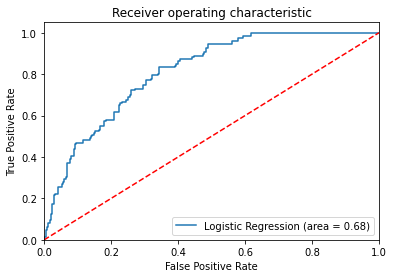

Accuracy of logistic regression classifier on test set: 0.74
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       251
           1       0.63      0.52      0.57       126

    accuracy                           0.74       377
   macro avg       0.70      0.68      0.69       377
weighted avg       0.73      0.74      0.73       377



In [179]:
# trains the model and produces the receiver operating characteristic (ROC) curve 
# returns classification report and accuracy
def trainModel(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    lr = LogisticRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_test)
    accuracy = 'Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test))
    classification = classification_report(y_test, y_pred)

    b = lr.intercept_[0]
    #print(lr.coef_.T)
    #print(b)

    # ROC curve
    logit_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('meth_ROC')     # saves the ROC curve
    plt.show()

    return accuracy, classification
modelResults = trainModel(newX, y, 0.2)

print(modelResults[0])
print(modelResults[1])

/Users/karenli/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/karenli/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1885, 2)


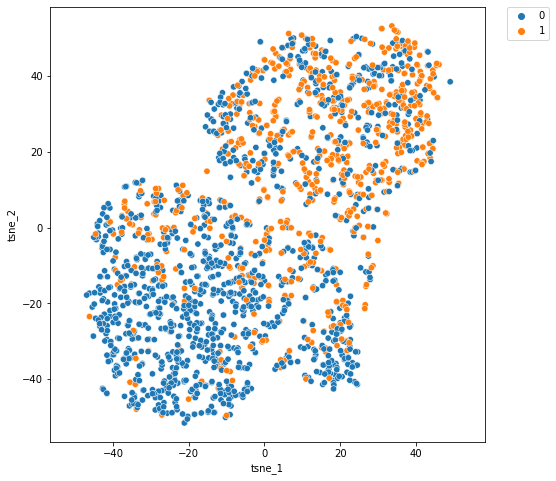

In [180]:
from sklearn.manifold import TSNE
import seaborn as sns

# aiming for TSNE embedding with 2 dimensions, for a 2-d graph
n_dim = 2
tsne = TSNE(n_dim)
tsne_result = tsne.fit_transform(newX)
print(tsne_result.shape)        # this should be 1885 x 2

# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig, ax = plt.subplots(1, figsize = (8, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=40)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.savefig('meth_tsnePlot')